In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Input, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
import random
import os

In [38]:
# Set seeds for reproducibility
random.seed(29)
np.random.seed(29)
tf.random.set_seed(29)
os.environ['PYTHONHASHSEED'] = '29'


In [39]:
# Load Google stock price data
google_train = pd.read_csv('Google_Stock_Price_Train.csv')
google_test = pd.read_csv('Google_Stock_Price_Test.csv')

# Load Occidental Petroleum stock price data
oxy_train = pd.read_excel('OXY_Stock_Price_Train.xlsx')
oxy_test = pd.read_excel('OXY_Stock_Price_Test.xlsx')


In [40]:
# Function to clean and preprocess data
def preprocess_data(df):
    df = df.copy()
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        # Convert to string to use .str methods
        df[col] = df[col].astype(str)
        # Remove commas
        df[col] = df[col].str.replace(',', '')
        # Convert to numeric, coercing errors
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Handle missing values if necessary
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
    return df

# Preprocess Google data
google_train = preprocess_data(google_train)
google_test = preprocess_data(google_test)

# Preprocess Occidental Petroleum data
oxy_train = preprocess_data(oxy_train)
oxy_test = preprocess_data(oxy_test)

google_train.describe()


,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,533.709833,537.880223,529.007409,712.669666,3.158107e+06
std,151.904442,153.008811,150.552807,164.752591,2.273726e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,404.115000,406.765000,401.765000,576.740000,1.621700e+06
50%,537.470000,540.750000,532.990000,695.675000,2.566150e+06
75%,654.922500,662.587500,644.800000,782.105000,4.122500e+06
max,816.680000,816.680000,805.140000,1216.830000,2.497790e+07


In [41]:
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Scaler for every feature
#Google
scalers = {}
for feature in features:
    scaler = MinMaxScaler(feature_range=(0, 1))
    google_train[feature] = scaler.fit_transform(google_train[[feature]])
    google_test[feature] = scaler.transform(google_test[[feature]])
    scalers[feature] = scaler

# OXY
for feature in features:
    scaler = MinMaxScaler(feature_range=(0, 1))
    oxy_train[feature] = scaler.fit_transform(oxy_train[[feature]])
    oxy_test[feature] = scaler.transform(oxy_test[[feature]])
    scalers[feature + '_oxy'] = scaler 



In [42]:
def create_sequences(data, N):
    X = []
    y = []
    for i in range(N, len(data)):
        X.append(data[i-N:i, :])  # All Features
        y.append(data[i, features.index('Close')])  
    X = np.array(X)
    y = np.array(y)
    return X, y

In [43]:
N=60
# Transfer DataFrame to NumPy
google_train_values = google_train[features].values
google_test_values = google_test[features].values

# Split to 80% training and 20% testing
train_size_google = int(len(google_train_values) * 0.8)
google_train_set = google_train_values[:train_size_google]
google_val_set = google_train_values[train_size_google:]

# create sequence for google
X_google_train, y_google_train = create_sequences(google_train_set, N)
X_google_val, y_google_val = create_sequences(google_val_set, N)

# create sequce for oxy
oxy_train_values = oxy_train[features].values
oxy_test_values = oxy_test[features].values

train_size_oxy = int(len(oxy_train_values) * 0.8)
oxy_train_set = oxy_train_values[:train_size_oxy]
oxy_val_set = oxy_train_values[train_size_oxy:]

X_oxy_train, y_oxy_train = create_sequences(oxy_train_set, N)
X_oxy_val, y_oxy_val = create_sequences(oxy_val_set, N)

input_shape_google = (X_google_train.shape[1], X_google_train.shape[2])  # (time step, feature)
input_shape_oxy = (X_oxy_train.shape[1], X_oxy_train.shape[2])


In [44]:
#RNN model
def build_rnn_model(input_shape_google):
    model = Sequential()
    model.add(Input(shape=input_shape_google))
    model.add(SimpleRNN(units=80, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=80))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # predict the next day's close price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [45]:
# LSTM model
def build_lstm_model(input_shape_oxy):
    model = Sequential()
    model.add(Input(shape=input_shape_oxy))
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=80))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
# , metrics=['mae']

In [46]:
# RNN Train for google
rnn_google = build_rnn_model(input_shape_google)
rnn_google_history = rnn_google.fit(X_google_train, y_google_train, epochs=30, batch_size=16,
                                    validation_data=(X_google_val, y_google_val), shuffle=False)
# LSTM Train for google
lstm_google = build_lstm_model(input_shape_google)
lstm_google_history = lstm_google.fit(X_google_train, y_google_train, epochs=30, batch_size=16,
                                      validation_data=(X_google_val, y_google_val), shuffle=False)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2449 - val_loss: 0.0060
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0738 - val_loss: 0.0056
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0512 - val_loss: 0.0029
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0356 - val_loss: 0.0099
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0273 - val_loss: 7.6448e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0244 - val_loss: 4.7936e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0202 - val_loss: 7.0247e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0176 - val_loss: 8.4313e-04
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0138 - val_loss: 4.7960e-04
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114 - val_loss: 0.0023
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - 

In [47]:
# RNN train for oxy
rnn_oxy = build_rnn_model(input_shape_oxy)
rnn_oxy_history = rnn_oxy.fit(X_oxy_train, y_oxy_train, epochs=30, batch_size=16,
                              validation_data=(X_oxy_val, y_oxy_val), shuffle=False)
# LSTM train for oxy
lstm_oxy = build_lstm_model(input_shape_oxy)
lstm_oxy_history = lstm_oxy.fit(X_oxy_train, y_oxy_train, epochs=30, batch_size=16,
                                validation_data=(X_oxy_val, y_oxy_val), shuffle=False)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2171 - val_loss: 0.0168
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0828 - val_loss: 0.0062
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0510 - val_loss: 0.0037
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0347 - val_loss: 0.0033
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0238 - val_loss: 0.0049
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0186 - val_loss: 0.0017
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0192 - val_loss: 0.0016
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0171 - val_loss: 0.0011
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0022
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0133 - val_loss: 9.4087e-04
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - v

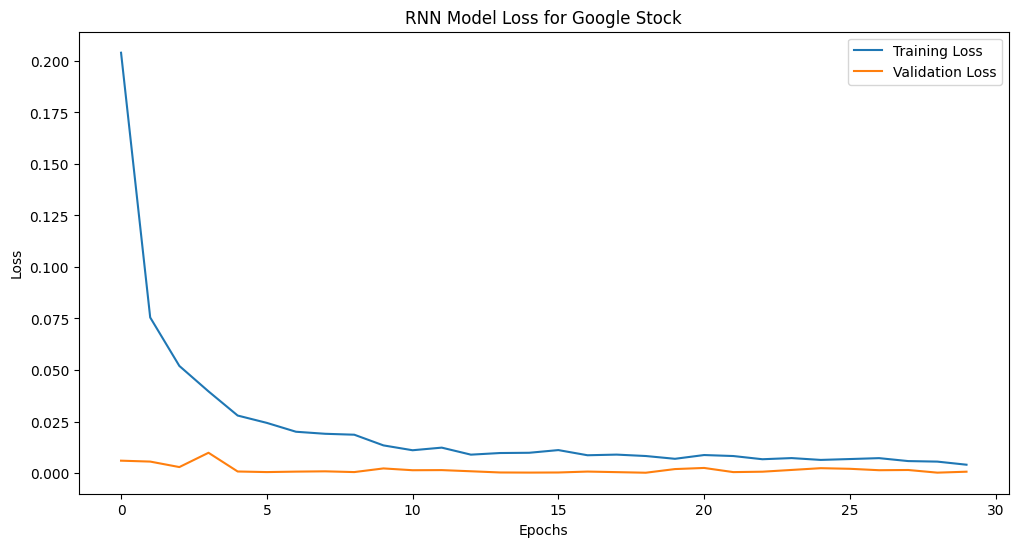

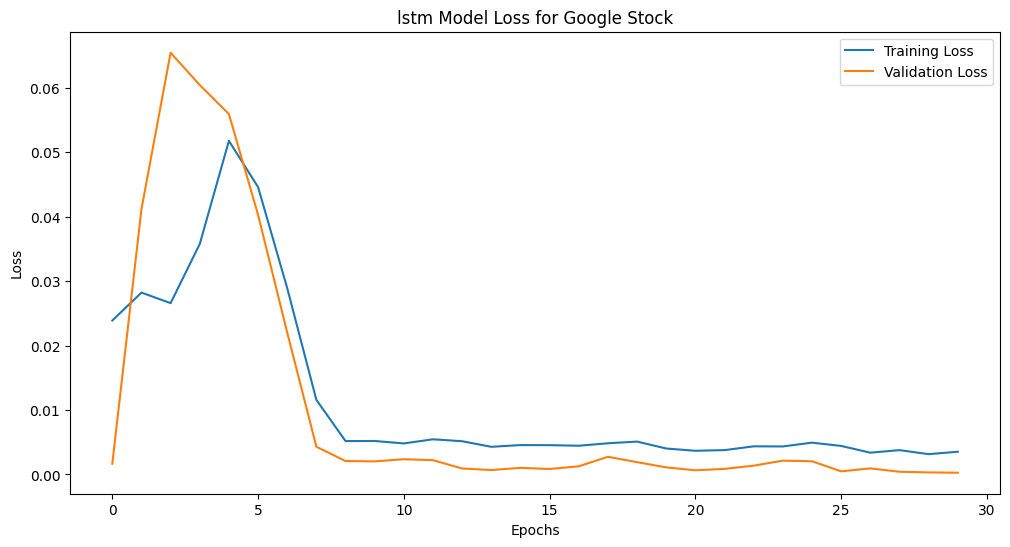

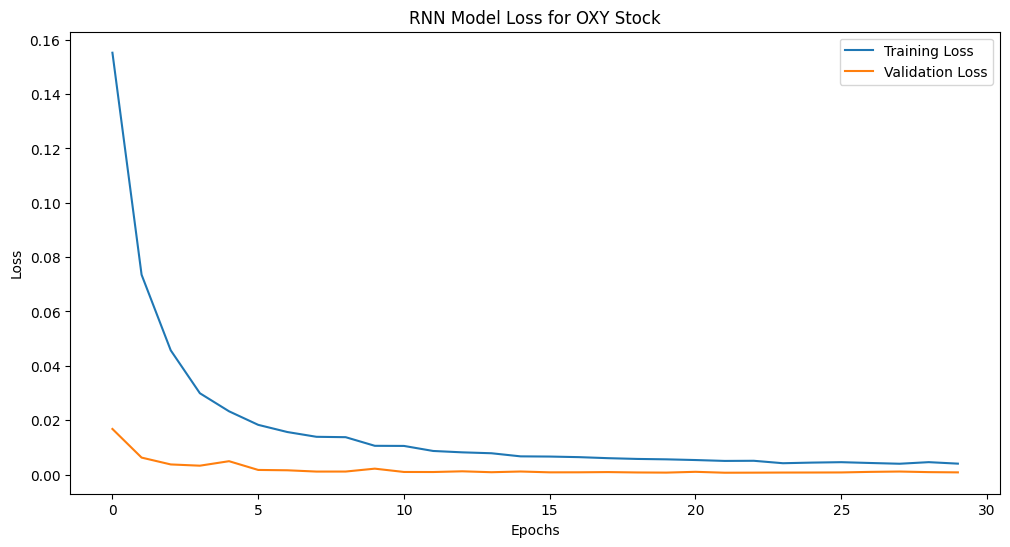

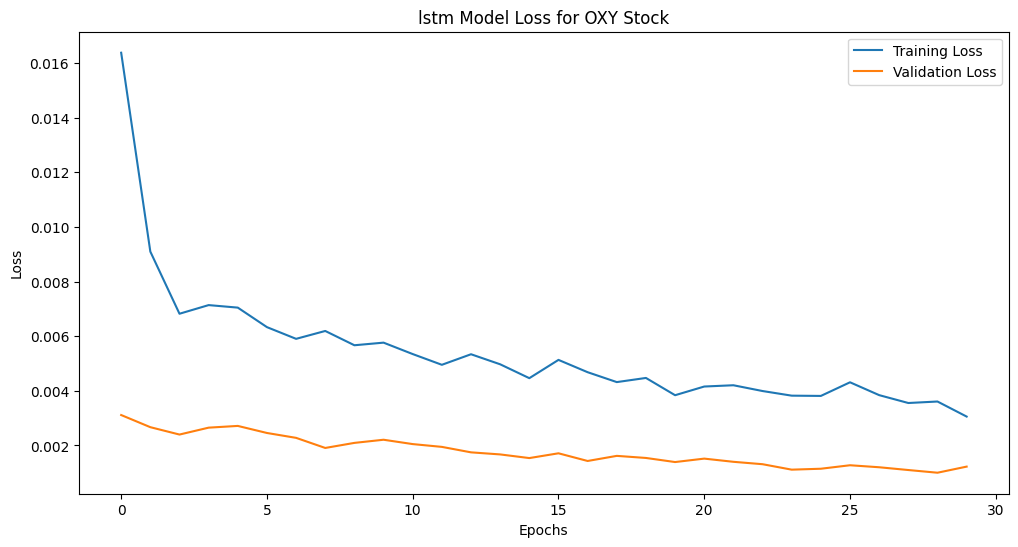

In [48]:
# plot the train loss and val loss
plt.figure(figsize=(12, 6))
plt.plot(rnn_google_history.history['loss'], label='Training Loss')
plt.plot(rnn_google_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss for Google Stock')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(lstm_google_history.history['loss'], label='Training Loss')
plt.plot(lstm_google_history.history['val_loss'], label='Validation Loss')
plt.title('lstm Model Loss for Google Stock')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rnn_oxy_history.history['loss'], label='Training Loss')
plt.plot(rnn_oxy_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss for OXY Stock')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(lstm_oxy_history.history['loss'], label='Training Loss')
plt.plot(lstm_oxy_history.history['val_loss'], label='Validation Loss')
plt.title('lstm Model Loss for OXY Stock')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Function to prepare test data
def prepare_test_data(train_data, test_data, N):
    total_data = np.concatenate((train_data, test_data), axis=0)
    inputs = total_data[len(train_data) - N:len(train_data) + len(test_data)]
    X_test = []
    for i in range(N, len(inputs)):
        X_test.append(inputs[i-N:i, :])
    X_test = np.array(X_test)
    return X_test


# Google
X_google_test = prepare_test_data(google_train_values, google_test_values, N)
rnn_google_predictions = rnn_google.predict(X_google_test)
lstm_google_predictions = lstm_google.predict(X_google_test)

# OXY
X_oxy_test = prepare_test_data(oxy_train_values, oxy_test_values, N)
rnn_oxy_predictions = rnn_oxy.predict(X_oxy_test)
lstm_oxy_predictions = lstm_oxy.predict(X_oxy_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


In [50]:
# Google close price
google_actual_scaled = google_test['Close'].values.reshape(-1, 1)
google_actual_inv = scalers['Close'].inverse_transform(google_actual_scaled)
# OXY close price
oxy_actual_scaled = oxy_test['Close'].values.reshape(-1, 1)
oxy_actual_inv = scalers['Close_oxy'].inverse_transform(oxy_actual_scaled)


In [51]:
# Inverse transform predictions
# Google
rnn_google_predictions_inv = scalers['Close'].inverse_transform(rnn_google_predictions)
lstm_google_predictions_inv = scalers['Close'].inverse_transform(lstm_google_predictions)

# OXY
rnn_oxy_predictions_inv = scalers['Close_oxy'].inverse_transform(rnn_oxy_predictions)
lstm_oxy_predictions_inv = scalers['Close_oxy'].inverse_transform(lstm_oxy_predictions)

In [52]:
def smape(actual, forecast):
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Google RNN
rnn_google_rmse = np.sqrt(mean_squared_error(google_actual_inv, rnn_google_predictions_inv))
google_train_close_inv = scalers['Close'].inverse_transform(google_train['Close'].values.reshape(-1, 1)).flatten()
rnn_google_smape = smape(google_actual_inv, rnn_google_predictions_inv)
rnn_google_mase = mase(google_actual_inv.flatten(), rnn_google_predictions_inv.flatten(), google_train_close_inv)
rnn_google_rmsle = rmsle(google_actual_inv, rnn_google_predictions_inv)

# Google LSTM
lstm_google_rmse = np.sqrt(mean_squared_error(google_actual_inv, lstm_google_predictions_inv))
lstm_google_smape = smape(google_actual_inv, lstm_google_predictions_inv)
lstm_google_mase = mase(google_actual_inv.flatten(), lstm_google_predictions_inv.flatten(), google_train_close_inv)
lstm_google_rmsle = rmsle(google_actual_inv, lstm_google_predictions_inv)


# OXY RNN
rnn_oxy_rmse = np.sqrt(mean_squared_error(oxy_actual_inv, rnn_oxy_predictions_inv))
oxy_train_close_inv = scalers['Close_oxy'].inverse_transform(oxy_train['Close'].values.reshape(-1, 1)).flatten()
rnn_oxy_smape = smape(oxy_actual_inv, rnn_oxy_predictions_inv)
rnn_oxy_mase = mase(oxy_actual_inv.flatten(), rnn_oxy_predictions_inv.flatten(), oxy_train_close_inv)
rnn_oxy_rmsle = rmsle(oxy_actual_inv, rnn_oxy_predictions_inv)

# OXY LSTM
lstm_oxy_rmse = np.sqrt(mean_squared_error(oxy_actual_inv, lstm_oxy_predictions_inv))
lstm_oxy_smape = smape(oxy_actual_inv, lstm_oxy_predictions_inv)
lstm_oxy_mase = mase(oxy_actual_inv.flatten(), lstm_oxy_predictions_inv.flatten(), oxy_train_close_inv)
lstm_oxy_rmsle = rmsle(oxy_actual_inv, lstm_oxy_predictions_inv)

print(f"Google RNN - RMSE: {rnn_google_rmse}, sMAPE: {rnn_google_smape}, MASE: {rnn_google_mase}, RMSLE: {rnn_google_rmsle}")
print(f"Google LSTM - RMSE: {lstm_google_rmse}, sMAPE: {lstm_google_smape}, MASE: {lstm_google_mase}, RMSLE: {lstm_google_rmsle}")
print(f"OXY RNN - RMSE: {rnn_oxy_rmse}, sMAPE: {rnn_oxy_smape}, MASE: {rnn_oxy_mase}, RMSLE: {rnn_oxy_rmsle}")
print(f"OXY LSTM - RMSE: {lstm_oxy_rmse}, sMAPE: {lstm_oxy_smape}, MASE: {lstm_oxy_mase}, RMSLE: {lstm_oxy_rmsle}")


Google RNN - RMSE: 25.7941799174538, sMAPE: 3.040036903829113, MASE: 3.272870658175226, RMSLE: 0.032478301305369266
Google LSTM - RMSE: 15.874427288400943, sMAPE: 1.6905182496133806, MASE: 1.8422264503190586, RMSLE: 0.01968714135837061
OXY RNN - RMSE: 0.8802324541822032, sMAPE: 1.0238247565413636, MASE: 0.7996490803932439, RMSLE: 0.01245413896222601
OXY LSTM - RMSE: 0.7517494525803706, sMAPE: 0.9539454319384029, MASE: 0.7434517744377985, RMSLE: 0.01067513368145654


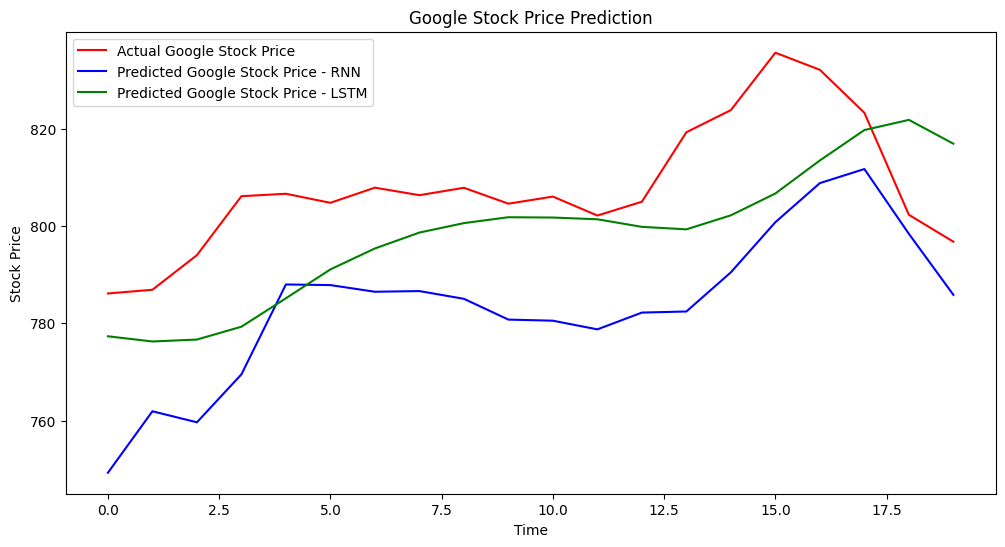

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(google_actual_inv, color='red', label='Actual Google Stock Price')
plt.plot(rnn_google_predictions_inv, color='blue', label='Predicted Google Stock Price - RNN')
plt.plot(lstm_google_predictions_inv, color='green', label='Predicted Google Stock Price - LSTM')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

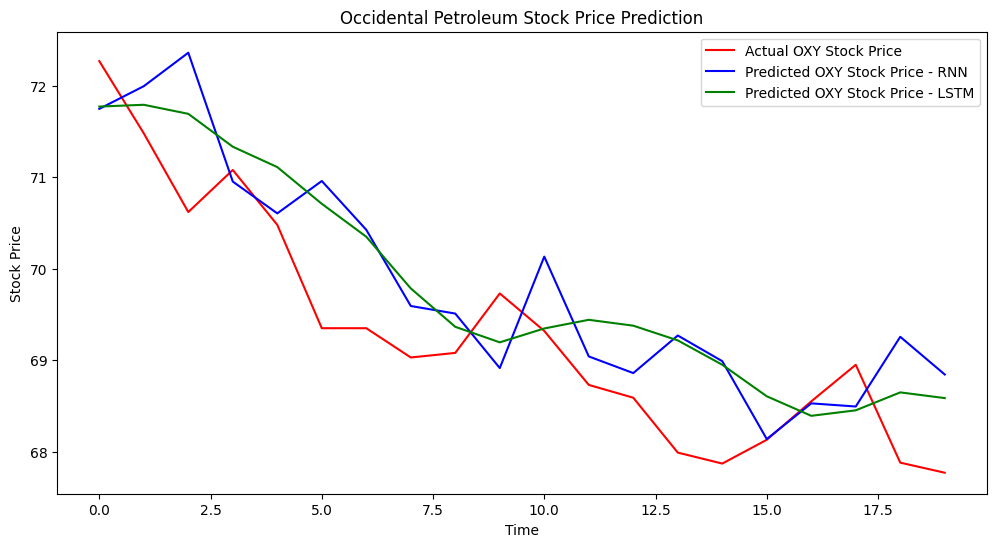

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(oxy_actual_inv, color='red', label='Actual OXY Stock Price')
plt.plot(rnn_oxy_predictions_inv, color='blue', label='Predicted OXY Stock Price - RNN')
plt.plot(lstm_oxy_predictions_inv, color='green', label='Predicted OXY Stock Price - LSTM')
plt.title('Occidental Petroleum Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
